In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

from PIL import Image
import warnings

# disable warnings
Image.MAX_IMAGE_PIXELS = None # image processing
# auto-reload functions before each instance running them
%load_ext autoreload
%autoreload 2

In [2]:
# Remote instance set-up cell
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cpu


In [3]:
# directory setup cell
repo = 'tree-finder/'
location = 'local'
save_files = False

# Local paths
local_root = '/Users/etriesch/dev/'
colab_root = '/content/drive/My Drive/git/'
aws_root = '/home/ec2-user/'

# define root
if location == 'local':
    root = local_root
elif location == 'google':
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    root = colab_root
elif location == 'aws':
    root = aws_root

repo_path = root + repo
model_path = repo_path + 'models/'
data_path = repo_path + 'data/'
results_path = repo_path + 'results/'
sys.path.append(repo_path)

In [4]:
# setup cell
from notebooks.viz_fns import show_image_batch, set_plt_settings, plot_accs
from notebooks.train_fns import flatten, Flatten, train_model
from notebooks.models import ResnetBinClassifier, ResnetTransferClassifier
from notebooks.data_processing import define_transforms, make_dataloaders, IMAGE_DIM, MEAN, STD

set_plt_settings()

# Make dataset and loaders
This includes augmenting my dataset

In [6]:
# define transformations
transforms = define_transforms(scale_up=1024, crop=1024, scale_out=IMAGE_DIM, mean=MEAN, std=STD, mirror=True, randomcrop=[50])

# create dataset by concatenating all transformations
binds = []
for t in transforms:
    df = dset.ImageFolder(root=data_path + 'images_bin', transform=transforms[t])
    binds.append(df)

binds = ConcatDataset(binds)
class_names = binds.datasets[0].classes
print('class names:', class_names)

# make dataloaders
dataloaders, ds_sizes = make_dataloaders(dataset=binds, subset=None, test_split=0.10, val_split=0.25, sampleN=4, batch_size=32, seed=None)

class names: ['nottree', 'tree']
dataloader sizes: {'all': 5200, 'train': 3510, 'validate': 1170, 'test': 520, 'sampler': 4}


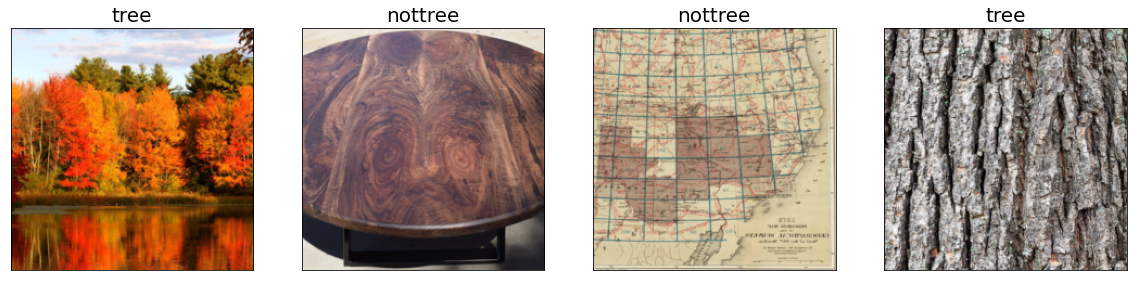

In [7]:
# visualize images
samp_input, samp_class = next(iter(dataloaders['sampler']))
samp_input, samp_class = samp_input.to(device), samp_class.to(device)

# print(type(imgs), type(labels))
show_image_batch(samp_input.cpu(), mean=MEAN, std=STD, 
                 title=[class_names[x] for x in samp_class])

# Retrain a pretrained model for binary classification of trees

## Overfit on small data

In [ ]:
small_data_train_size = 500
small_data_validate_size = 100
small_batch_size = 25
small_loaders = {}
small_loaders['train'] = DataLoader(binds, batch_size=small_batch_size,
                           sampler=sampler.SubsetRandomSampler(np.random.randint(0, len(binds), small_data_train_size)))
small_loaders['validate'] = DataLoader(binds, batch_size=small_batch_size,
                           sampler=sampler.SubsetRandomSampler(np.random.randint(0, len(binds), small_data_validate_size)))
small_ds_sizes = {'train':small_data_train_size, 'validate':small_data_validate_size}

In [ ]:
model = ResnetBinClassifier(resnet50=False)
model = model.to(device)
print(model.get_grad_state())
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)
scheduler_lr = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) #lr decay

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

loading pretrained resnet18...
{'unfrozen': ['fc'], 'frozen': ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']}


train epoch: [1/2] Loss: 0.7208 ACC@1: 48.67%:  60%|██████████████████            | 12/20 [03:39<02:10, 16.36s/it]/opt/conda/envs/pytorch/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
validate epoch: [2/2] Loss: 0.3316 ACC@1: 97.00%: 100%|█████████████████████████████| 4/4 [01:06<00:00, 16.51s/it]


Returning best model, with validation accuracy 0.97


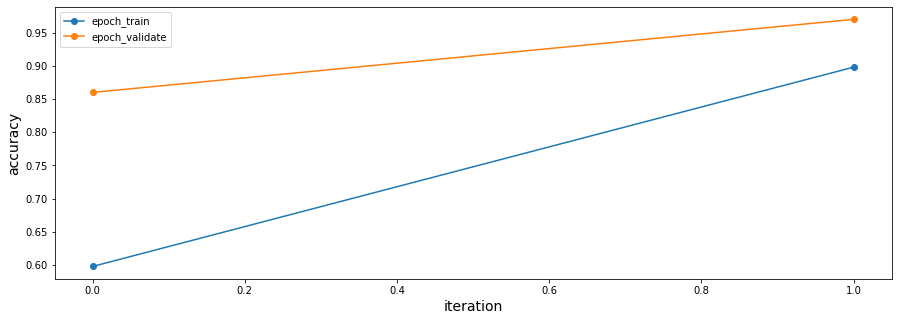

In [ ]:
acc_history = train_model(model, criterion, optimizer, scheduler_lr,
                          small_loaders, small_ds_sizes, device, 2)
plot_accs({key: acc_history[key] for key in ['epoch_train', 'epoch_validate']})

## Train using entire dataset

In [ ]:
model = ResnetTransferClassifier(num_classes=2, retrain_last_cnblock=False)
model = model.to(device)
print(model.get_grad_state())
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)
scheduler_lr = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1) # lr decay

{'unfrozen': ['avgpool', 'fc'], 'frozen': ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4']}


In [ ]:
acc_history = train_model(model, criterion, optimizer, scheduler_lr,
                          dataloaders, ds_sizes, device, 10)
plot_accs({key: acc_history[key] for key in ['epoch_train', 'epoch_validate']})

# save to file
if save_files:
  # MODEL
  torch.save(model.state_dict(), model_path + 'ResnetBinClassifier.pt')
  # RESULTS
  filename = 'acc_resnetbinclassifier.csv'
  epoch_results = pd.DataFrame({key: torch.Tensor(acc_history[key]) for key in ['epoch_train', 'epoch_validate']})
  epoch_results.to_csv(results_path + filename)

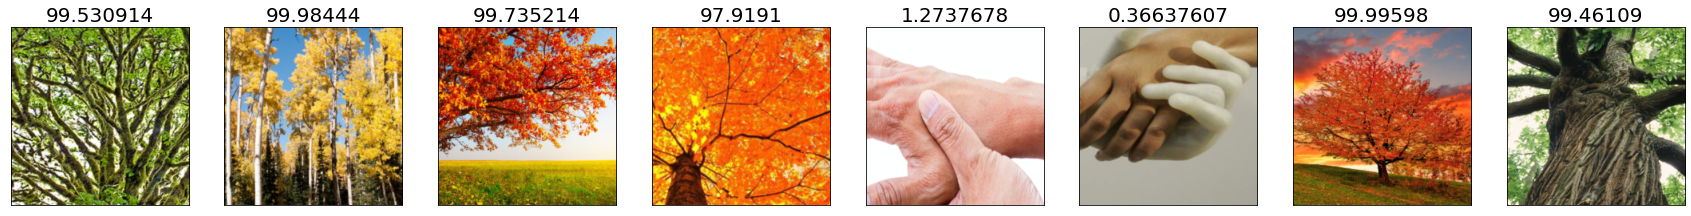

In [ ]:
# print scores for sample of images
scores = model(samp_input)
percentage = F.softmax(scores, dim=1) * 100
# print trees and score for detecting tree for a random sample of images
tree_likelihood = percentage[:,1].cpu().detach().numpy()
show_image_batch(samp_input.cpu(), MEAN, STD, title=tree_likelihood)

In [ ]:
# git saver cell
%cd '/content/drive/My Drive /git/tree-finder'
!git config --global user.email "erich.j.trieschman@gmail.com"
!git config --global user.name "Erich Trieschman"

!git add .
!git commit -m 'rerun pretrained model'
!git push

/content/drive/My Drive /git/tree-finder
[main f51f0e5] rerun pretrained model
 8 files changed, 18 insertions(+), 10 deletions(-)
 delete mode 100644 models/resnet.pt
 rewrite notebooks/__pycache__/data_processing.cpython-37.pyc (65%)
 rewrite notebooks/preprocess_images.ipynb (77%)
 rewrite notebooks/train_binary_tree_classifier.ipynb (79%)
 rewrite notebooks/train_species_classifiers.ipynb (97%)
 create mode 100644 results/acc_resnetbinclassifier.csv
Counting objects: 13, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (13/13), done.
Writing objects: 100% (13/13), 3.74 MiB | 1.13 MiB/s, done.
Total 13 (delta 7), reused 0 (delta 0)
remote: Resolving deltas: 100% (7/7), completed with 7 local objects.
remote: warning: See http://git.io/iEPt8g for more information.
remote: warning: File models/ResnetBinClassifier.pt is 90.98 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: GH001: Large files detected. You may want to t